### Additional Analysis & Fails

In this Jupyter notebook, there are all analysis that didn't make it into the report or the presentation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.stats import spearmanr
from scipy.stats import ranksums

#Import Pyrosetta
import pyrosetta; pyrosetta.init()
import pyrosetta
from Bio.PDB import PDBParser, PDBIO
import pandas as pd
import os
from pyrosetta.rosetta.protocols.minimization_packing import MinMover
from pyrosetta.rosetta.core.kinematics import MoveMap
from pyrosetta.rosetta.protocols.relax import FastRelax


PyRosetta-4 2023 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python310.Release 2023.27+release.e3ce6ea9faf661ae8fa769511e2a9b8596417e58 2023-07-07T12:00:46] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python310.Release r353 2023.27+release.e3ce6ea e3ce6ea9faf661ae8fa769511e2a9b8596417e58 http://www.pyrosetta.org 2023-07-07T12:00:46
core.init: command: PyRosetta -ex1 -ex2aro -database /home/rebeccalinux/miniconda3/lib/python3.10/site-packages/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=960293095 seed_offset=0 real_seed=960293095 thread_index=0
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=960293095 RG_type=mt19937


Prediction of ddG

In [ ]:
import pyrosetta
from Bio.PDB import PDBParser, PDBIO

# Path to the downloaded PDB file
pdb_file = '/mnt/c/Users/uni.rebecca.ress/Documents/rebecca.ress/Universität Heidelberg/4. Fachsemester/4. Fachsemester/Bioinformatik Projekt Niopek/Daten/av.pdb'

# Create PDB parser object
parser = PDBParser()

# Open the Biopython PDB object
biopython_structure = parser.get_structure('protein', pdb_file)

# Create temporary PDB file
temp_pdb_file = 'temp.pdb'

# Create PDBIO object
pdbio = PDBIO()

# Save the PDB file
pdbio.set_structure(biopython_structure)
pdbio.save(temp_pdb_file)

# Convert the PDB file to a PyRosetta pose
pyrosetta.init()
pose = pyrosetta.pose_from_pdb(temp_pdb_file)

# Define the mutation
old_aa = 'K'
position = 3
new_aa = 'R'

# Load the wildtype sequence from the pose
wildtype_sequence = pose.sequence()

# Perform the mutation
mutated_sequence = wildtype_sequence
position = position - 1  # Convert to 0-based index
mutated_sequence = mutated_sequence[:position] + new_aa + mutated_sequence[position+1:]

# Generate the mutated pose from the mutated sequence
mutated_pose = pyrosetta.pose_from_sequence(mutated_sequence)

# Create a ScoreFunction object
scorefxn = pyrosetta.get_score_function()

# Create a Monte Carlo object
monte_carlo = pyrosetta.rosetta.protocols.moves.MonteCarlo(scorefxn, 1.0)

# Perform Monte Carlo sampling
monte_carlo.set_temperature(0.0)
pose_copy = mutated_pose.clone()
monte_carlo.boltzmann(pose_copy)

# Calculate the ΔG value for the mutation
mutant_energy = scorefxn(mutated_pose)

# Print the mutated sequence
print(f"Mutated sequence: {mutated_sequence}")

# Print the ΔG value for the mutation
print(f"ΔG value for {old_aa}{position}{new_aa}: {mutant_energy}")

In [2]:
csv_file_path = '/mnt/c/Users/uni.rebecca.ress/Documents/rebecca.ress/Universität Heidelberg/4. Fachsemester/4. Fachsemester/Bioinformatik Projekt Niopek/Daten/reb09_df_dG_ddG.csv'
df_ddG_single = pd.read_csv(csv_file_path)

# Ausgabe des DataFrames
print(df_ddG_single)

     mutation    ΔG value  DMS score old AA  Position new AA         ΔΔG
0         K3R -783.379017   3.738586      K         3      R -170.459576
1         K3Q -783.379034   3.750487      K         3      Q -170.459559
2         K3E -783.379041   3.666278      K         3      E -170.459551
3         K3M -783.379064   3.698336      K         3      M -170.459529
4         K3T -783.379081   3.629775      K         3      T -170.459512
...       ...         ...        ...    ...       ...    ...         ...
1074    L236M -783.393562   3.585794      L       236      M -170.445031
1075    L236Q -783.393576   3.748580      L       236      Q -170.445017
1076    L236R -783.393585   3.706509      L       236      R -170.445008
1077    L236V -783.393598   3.715704      L       236      V -170.444995
1078    L236P -783.393612   3.706238      L       236      P -170.444980

[1079 rows x 7 columns]


Analysis regarding the relationship between ddG and DMS score

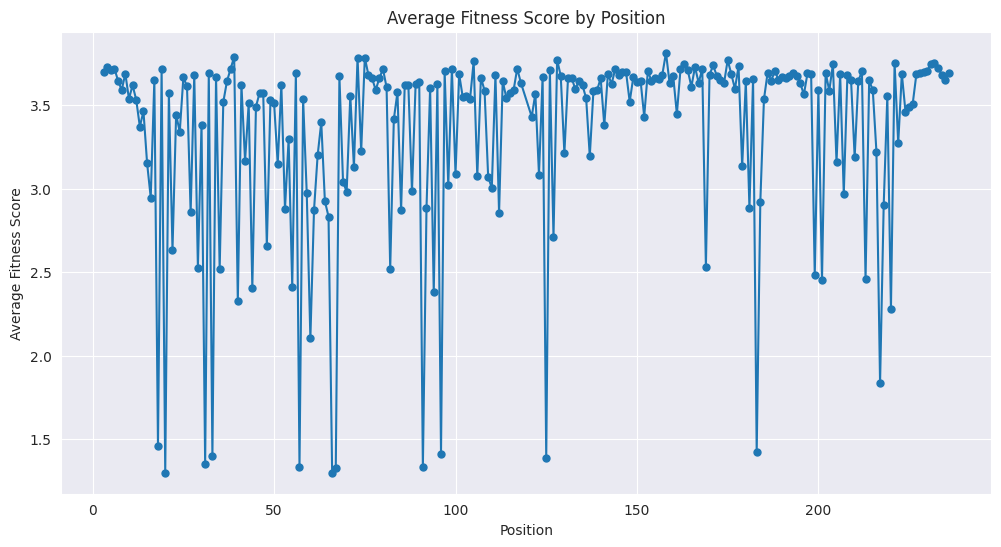

In [3]:
# Group the data by position and calculate the average fitness score for each position
grouped_data = df_ddG_single.groupby('Position')['DMS score'].mean()

# Create a line plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(grouped_data.index, grouped_data.values, marker='o', markersize=5)
ax.set_xlabel('Position')
ax.set_ylabel('Average Fitness Score')
ax.set_title('Average Fitness Score by Position')

# Show the plot
plt.show()

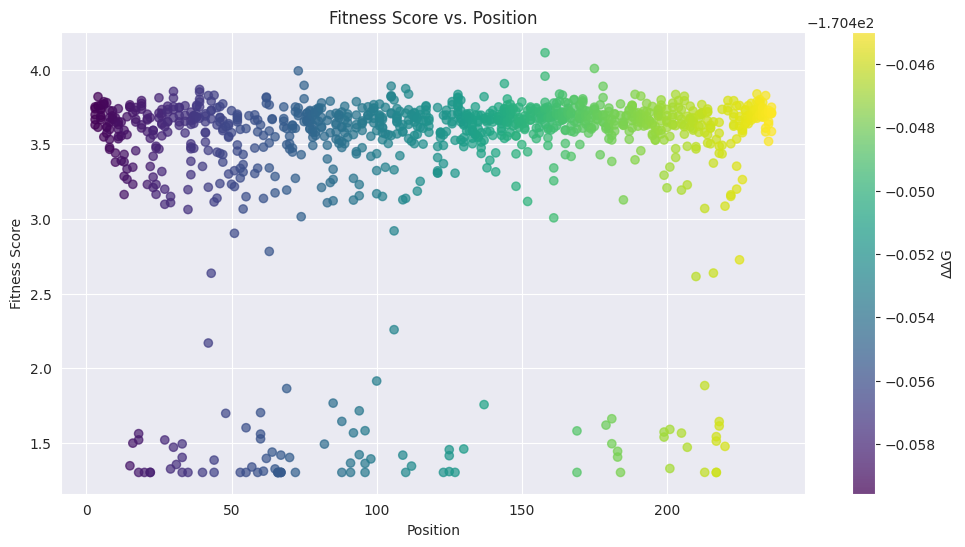

In [4]:

# Create a scatter plot
fig, ax = plt.subplots(figsize=(12, 6))
scatter = ax.scatter(df_ddG_single['Position'], df_ddG_single['DMS score'], c=df_ddG_single['ΔΔG'], cmap='viridis', alpha=0.7)
ax.set_xlabel('Position')
ax.set_ylabel('Fitness Score')
ax.set_title('Fitness Score vs. Position')

# Create a colorbar using the scatter plot as the mappable
cbar = plt.colorbar(scatter)
cbar.set_label('ΔΔG')

# Show the plot
plt.show()

In [9]:
import requests
import pandas as pd

# URL to the GFF file
url = "https://rest.uniprot.org/uniprotkb/P42212.gff"

# Send a GET request and retrieve the data
response = requests.get(url)
data = response.text

# Process the GFF data
feature_list = []

for line in data.split("\n"):
    if line.startswith("P42212"):
        columns = line.split("\t")
        feature_type = columns[2]
        start_pos = columns[3]
        end_pos = columns[4]

        if feature_type in ["Turn", "Helix", "Beta strand"]:
            feature_list.append([feature_type, start_pos, end_pos])  # Add feature line to the list

# Create a DataFrame
df_structure = pd.DataFrame(feature_list, columns=["Structure", "Start", "End"])

# Print the DataFrame
print(df_structure)

      Structure Start  End
0          Turn     1    3
1         Helix     5    8
2   Beta strand    12   22
3   Beta strand    25   36
4         Helix    37   39
5   Beta strand    41   48
6   Beta strand    50   52
7         Helix    57   60
8         Helix    61   64
9          Turn    65   67
10        Helix    69   71
11        Helix    72   74
12        Helix    76   81
13        Helix    83   86
14         Turn    87   90
15  Beta strand    92  100
16  Beta strand   101  103
17  Beta strand   105  115
18  Beta strand   118  129
19  Beta strand   132  134
20         Turn   135  139
21  Beta strand   141  147
22  Beta strand   148  154
23  Beta strand   158  171
24         Turn   172  174
25  Beta strand   176  191
26  Beta strand   198  208
27        Helix   209  213
28  Beta strand   215  228
29        Helix   233  236


Analysis regarding interesting Mutations; here only single mutations

In [5]:
import pandas as pd

# Liste der Einzelmuationen
mutations = ['K156R', 'I123V', 'D197G', 'K101E', 'I128T', 'D117G', 'K214E', 'K209R', 'K113R', 'K79R']

# Filtern des DataFrames für die gewünschten Einzelmuationen
filtered_df = df_ddG_single[df_ddG_single['mutation'].isin(mutations)]

# Ausgabe des DataFrames
print(filtered_df[['mutation', 'ΔΔG', 'DMS score']])

    mutation         ΔΔG  DMS score
329     K79R -170.454704   3.731695
434    K101E -170.453241   3.696324
491    K113R -170.452463   3.682043
508    D117G -170.452227   3.729283
523    I123V -170.452025   3.694392
545    I128T -170.451735   3.815479
688    K156R -170.449847   3.710919
892    D197G -170.447256   3.727643
955    K209R -170.446477   3.644984
978    K214E -170.446197   3.719622


In [6]:

mutations = ['K156R', 'I123V', 'D197G', 'K101E', 'I128T', 'D117G', 'K214E', 'K209R', 'K113R', 'K79R']

# Filtere den DataFrame nach den Mehrfachmutationen, die die gegebenen Mutationen enthalten
multiple_mutations_data = df_ddG_single[df_ddG_single['mutation'].str.contains('|'.join(mutations))]
multiple_mutations_data['searched_mutation'] = multiple_mutations_data['mutation'].apply(lambda x: ', '.join(m for m in mutations if m in x))

# Sortiere den DataFrame nach der neuen Spalte searched_mutation
sorted_output_df = multiple_mutations_data.sort_values(by='searched_mutation')

# Zeige den sortierten DataFrame an
print(sorted_output_df[['searched_mutation', 'mutation', 'ΔΔG', 'DMS score']])

    searched_mutation mutation         ΔΔG  DMS score
508             D117G    D117G -170.452227   3.729283
892             D197G    D197G -170.447256   3.727643
523             I123V    I123V -170.452025   3.694392
545             I128T    I128T -170.451735   3.815479
434             K101E    K101E -170.453241   3.696324
491             K113R    K113R -170.452463   3.682043
688             K156R    K156R -170.449847   3.710919
955             K209R    K209R -170.446477   3.644984
978             K214E    K214E -170.446197   3.719622
329              K79R     K79R -170.454704   3.731695


/tmp/ipykernel_524/457496406.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multiple_mutations_data['searched_mutation'] = multiple_mutations_data['mutation'].apply(lambda x: ', '.join(m for m in mutations if m in x))


In [7]:
import pandas as pd

mutations = ['K156R', 'I123V', 'D197G', 'K101E', 'I128T', 'D117G', 'K214E', 'K209R', 'K113R', 'K79R']

# Filtere den DataFrame nach den Mehrfachmutationen, die die gegebenen Mutationen enthalten
multiple_mutations_data = df_ddG_single[df_ddG_single['mutation'].str.contains('|'.join(mutations))]
multiple_mutations_data['searched_mutation'] = multiple_mutations_data['mutation'].apply(lambda x: ', '.join(m for m in mutations if m in x))

# Sortiere den DataFrame nach der neuen Spalte searched_mutation
sorted_output_df = multiple_mutations_data.sort_values(by='searched_mutation')

# Zeige den sortierten DataFrame an
print(sorted_output_df[['searched_mutation', 'mutation', 'ΔΔG', 'DMS score']])

    searched_mutation mutation         ΔΔG  DMS score
508             D117G    D117G -170.452227   3.729283
892             D197G    D197G -170.447256   3.727643
523             I123V    I123V -170.452025   3.694392
545             I128T    I128T -170.451735   3.815479
434             K101E    K101E -170.453241   3.696324
491             K113R    K113R -170.452463   3.682043
688             K156R    K156R -170.449847   3.710919
955             K209R    K209R -170.446477   3.644984
978             K214E    K214E -170.446197   3.719622
329              K79R     K79R -170.454704   3.731695


/tmp/ipykernel_524/2703314584.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multiple_mutations_data['searched_mutation'] = multiple_mutations_data['mutation'].apply(lambda x: ', '.join(m for m in mutations if m in x))
